Dataset didapat dari cityscape

In [40]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, add, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# dataset path
os.listdir("/content/drive/MyDrive/dataset/")

['final_project.py',
 'annotations_prepped_train',
 'images_prepped_test',
 'images_prepped_train',
 'annotations_prepped_test']

<h3> Train Data </h3>

In [4]:
img_path = "/content/drive/MyDrive/dataset/images_prepped_train/"
annot_path = "/content/drive/MyDrive/dataset/annotations_prepped_train/"
list_img = np.sort(next(os.walk(img_path), (None, None, []))[2])
list_annot = np.sort(next(os.walk(annot_path), (None, None, []))[2])  
len(list_img), len(list_annot)

(367, 367)

In [5]:
list_img[2], list_annot[2]


('0001TP_006750.png', '0001TP_006750.png')

In [6]:
import glob

train_images_dir = sorted(glob.glob(img_path+'/*.png'))
train_annotations_dir = sorted(glob.glob(annot_path+'/*.png'))


Test Data

In [7]:
img_test_path = "/content/drive/MyDrive/dataset/images_prepped_test/"
annot_test_path = "/content/drive/MyDrive/dataset/annotations_prepped_test/"
list_img_test = np.sort(next(os.walk(img_test_path), (None, None, []))[2])
list_annot_test = np.sort(next(os.walk(annot_test_path), (None, None, []))[2])  
len(list_img_test), len(list_annot_test)

(101, 101)

In [8]:
import glob

test_images_dir = sorted(glob.glob(img_test_path+'/*.png'))
test_annotations_dir = sorted(glob.glob(annot_test_path+'/*.png'))

Preprocessing

In [9]:
images = []
for img in train_images_dir:
    n = cv2.imread(img)
    images.append(n)

In [10]:
seg_masks = []
for img in train_annotations_dir:
    n = cv2.imread(img)
    seg_masks.append(n)

In [11]:
test_images = []
for img in test_images_dir:
    n = cv2.imread(img)
    n = cv2.resize(n, (128,128))
    test_images.append(n)

In [12]:
#read for annot test images
annotations_test = []
for img in test_annotations_dir:
    n = cv2.imread(img)
    annotations_test.append(n)

In [13]:
def get_colored_segmentation_image(seg, colors,
                                    n_classes):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                             * (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                             * (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                             * (colors[c][2])).astype('uint8')
    return seg_img

# initiate fix colors list
class_colors = [(128,0,0), (170,110, 40), (128,128,0), (0,128,128), (0,0,128), (230,25,75), (245,130,48), (255,255,25), (210,245,60), (240,50,230),
               (128,128,128), (220,190,255), (255,215,180), (70,140,240), (0,130,200)]


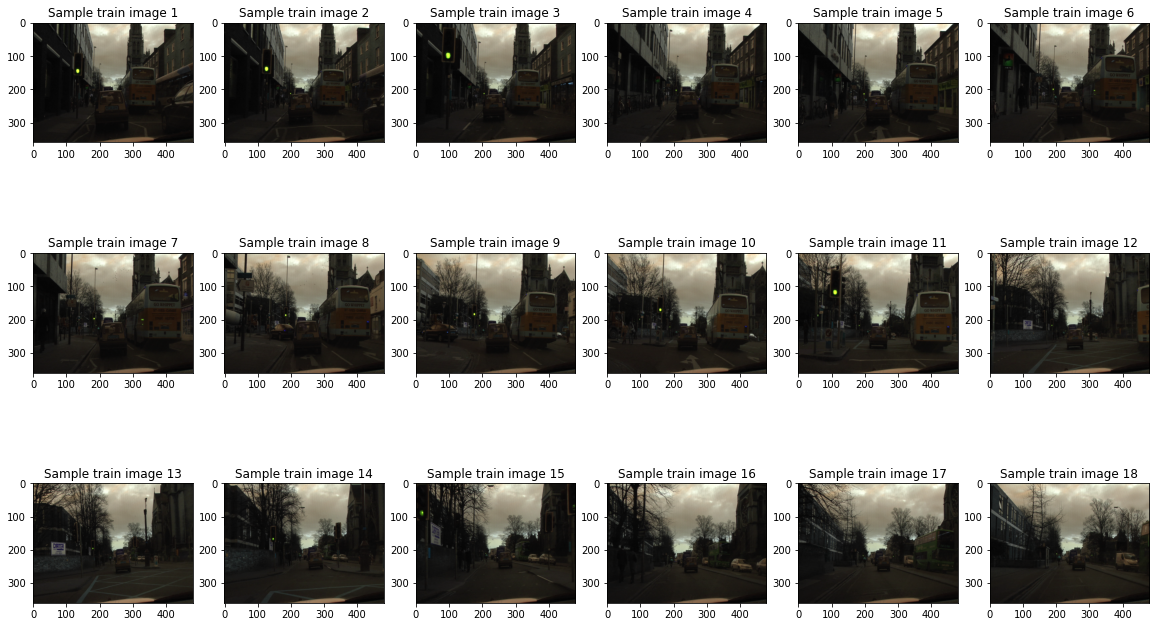

In [14]:
#Plot sample of train images
fig = plt.figure(figsize = (20,12))

for index in range(18):
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train image {}".format(index+1))
    ax.imshow(images[index], cmap='gray')

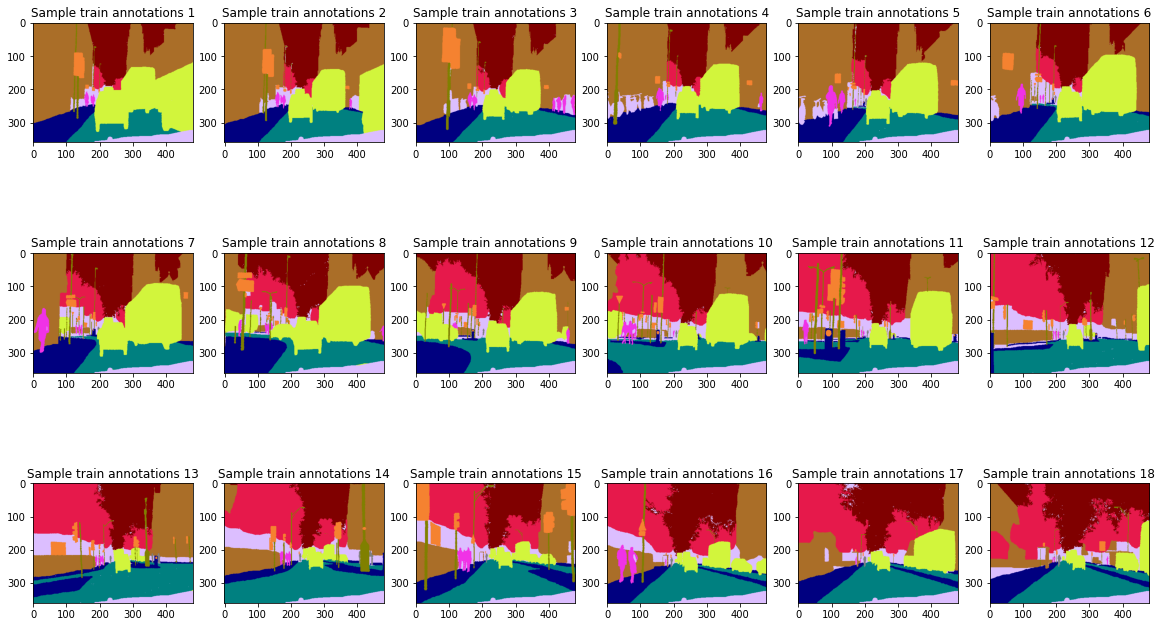

In [15]:
#Plot sample of train annotations
fig = plt.figure(figsize = (20,12))


for index in range(18):
#     image = mpimg.imread(os.path.join(train_annotations_dir, os.listdir(train_annotations_dir)[index]))
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train annotations {}".format(index+1))
    ax.imshow(get_colored_segmentation_image(seg_masks[index],n_classes=12,colors=class_colors))


In [16]:
images = []
for img in train_images_dir:
    n = cv2.imread(img)
    n = cv2.resize(n, (128,128))
    images.append(n)

In [17]:
seg_masks = []
for img in train_annotations_dir:
    n = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    n = cv2.resize(n,(128,128))
    seg_masks.append(n)

In [18]:
# All train annotation
for list_annot in os.listdir(annot_path):
    all_msk = cv2.imread(os.path.join(annot_path, list_annot), 0)
all_msk.shape


(360, 480)

In [19]:
test_images = []
for img in test_images_dir:
    n = cv2.imread(img)
    n = cv2.resize(n, (128,128))
    test_images.append(n)

In [20]:
annotations_test = []
for img in test_annotations_dir:
    n = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    n = cv2.resize(n,(128,128))
    annotations_test.append(n)

In [21]:
print("shape of one sample image in train images dataset: {}".format(images[0].shape))
print("\nshape of one sample image in train annotations dataset: {}".format(seg_masks[0].shape))

shape of one sample image in train images dataset: (128, 128, 3)

shape of one sample image in train annotations dataset: (128, 128)


In [22]:
images = np.array(images)
seg_masks = np.array(seg_masks)

In [23]:
seg_masks = np.expand_dims(seg_masks, axis=-1)


In [24]:
annotations_test = np.array(annotations_test)
annotations_test = np.expand_dims(annotations_test, axis=-1)

In [25]:
# Split Dataset
x_train, x_test, y_train, y_test = train_test_split(images, seg_masks, test_size = 0.2, random_state = 5)

x_train = np.array(images)
x_test = np.array(test_images)
y_train = np.array(seg_masks).squeeze()
y_test = np.array(annotations_test)


In [26]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (367, 128, 128, 3)
y_train shape: (367, 128, 128)


In [27]:
y_train.shape

(367, 128, 128)

In [28]:
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))


x_test shape: (101, 128, 128, 3)
y_test shape: (101, 128, 128, 1)


In [29]:
classes = np.unique(y_train)
num_class = len(classes)
print("classes in image: {} : \n {}".format(num_class, classes)) 

classes in image: 12 : 
 [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [30]:
train = tf.keras.utils.to_categorical(y_train, num_class)
test = tf.keras.utils.to_categorical(y_test, num_class)

Build Model and Training

In [31]:
height = x_train.shape[1]
width = x_train.shape[2]
channel = x_train.shape[3]


In [32]:
#Unet model

inputs = tf.keras.Input((width,height,channel))

conv1 = Conv2D(64, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(inputs)
conv1 = Conv2D(64, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv1)
pool1 = MaxPooling2D(2,2)(conv1)

conv2 = Conv2D(128, 3, activation= 'relu', kernel_initializer='he_normal', padding = 'same')(pool1)
conv2 = Conv2D(128, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(conv2)
pool2 = MaxPooling2D(2,2)(conv2)

conv3 = Conv2D(256, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(pool2)
conv3 = Conv2D(256, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv3)
pool3 = MaxPooling2D(2,2)(conv3)

conv4 = Conv2D(512, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(pool3)
conv4 = Conv2D(512, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(conv4)
# dropout4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(2,2)(conv4)


conv5 = Conv2D(1024, 3, activation= 'relu',kernel_initializer='he_normal', padding = 'same')(pool4)
conv5 = Conv2D(1024, 3, activation= 'relu', kernel_initializer='he_normal',padding = 'same')(conv5)
dropout5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(dropout5))
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', kernel_initializer='he_normal', padding = 'same')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)
,
up9 = Conv2D(64, 2, activation = 'relu', kernel_initializer='he_normal', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal', padding = 'same')(conv9)

conv9 = Conv2D(64, 3, activation = 'relu', kernel_initializer='he_normal',padding = 'same')(conv9)
conv10 = Conv2D(12, 1, activation = 'softmax')(conv9)

model = tf.keras.Model(inputs,conv10)
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [33]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.85:
                print("\nReached 85% validation accuracy so cancelling training!") 
                self.model.stop_training = True


In [34]:
callbacks = myCallback()


history = model.fit(
    x_train, 
    train, 
    validation_data=(x_test, test), 
    epochs=50,
    batch_size=4,
    callbacks=[callbacks]
)


Epoch 1/50
92/92 [==============================] - 26s 146ms/step - loss: 517.6136 - accuracy: 0.3402 - val_loss: 2.0272 - val_accuracy: 0.4702
Epoch 2/50
92/92 [==============================] - 10s 109ms/step - loss: 1.5512 - accuracy: 0.5897 - val_loss: 1.5052 - val_accuracy: 0.5434
Epoch 3/50
92/92 [==============================] - 10s 104ms/step - loss: 1.1968 - accuracy: 0.6536 - val_loss: 1.2614 - val_accuracy: 0.5900
Epoch 4/50
92/92 [==============================] - 10s 105ms/step - loss: 1.0738 - accuracy: 0.6762 - val_loss: 1.2260 - val_accuracy: 0.5820
Epoch 5/50
92/92 [==============================] - 10s 105ms/step - loss: 0.9775 - accuracy: 0.7002 - val_loss: 1.0777 - val_accuracy: 0.6319
Epoch 6/50
92/92 [==============================] - 10s 105ms/step - loss: 0.9039 - accuracy: 0.7222 - val_loss: 1.1176 - val_accuracy: 0.6330
Epoch 7/50
92/92 [==============================] - 10s 106ms/step - loss: 0.8653 - accuracy: 0.7381 - val_loss: 1.1905 - val_accuracy: 0.62

<h3> Training Evaluation </h3>

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


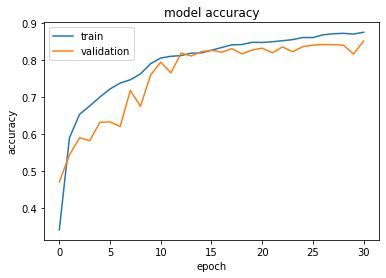

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

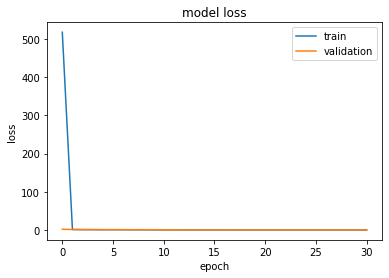

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [42]:
model.save("/content/drive/MyDrive/dataset/" + 'checkpoints/unet_model.h5')

In [43]:
load = tf.keras.models.load_model("/content/drive/MyDrive/dataset/" + 'checkpoints/unet_model.h5')

In [44]:
y_pred=load.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(101, 128, 128)

IoU

In [46]:
y_pred= load.predict(x_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(101, 128, 128)

In [47]:
#Using built in keras function
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)   
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.40490112


In [48]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

In [49]:
val = 0
total = 0
res = []

for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    
    for x in range(n_classes):
        if x != i:
            sum2 = values[x, i] + sum2  
        else:
            continue
    total = sum1 + sum2
    res.append(val/total)
    print("IoU class {}: {}".format(i,res[i]))

IoU class 0: 0.9307155077755931
IoU class 1: 0.7616564187844388
IoU class 2: 0.0010253983278119578
IoU class 3: 0.9353256003420155
IoU class 4: 0.75
IoU class 5: 0.8012513556881822
IoU class 6: 0.043965804374375486
IoU class 7: 0.033077144088493035
IoU class 8: 0.4477833128001857
IoU class 9: 0.0043997485857950975
IoU class 10: 0.0001918649270913277
IoU class 11: 0.14942143948766465


<BarContainer object of 12 artists>

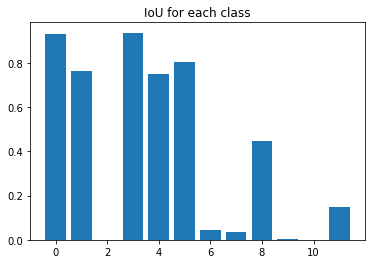

In [50]:
#plot IOU
index = []
for i in range (len(res)):
    index.append(i)
    
plt.title("IoU for each class")
plt.bar(index, res)

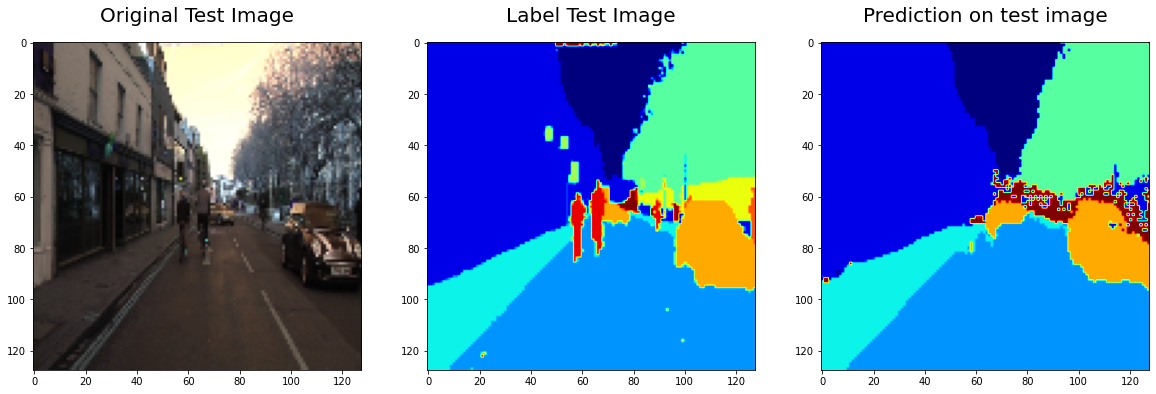

In [51]:
#Plot Prediction Image

#num = random.randint(0,len(x_test))
num = 3

plt.figure(figsize=(20, 20))

plt.subplot(231)
plt.title('Original Test Image', fontsize=20, pad=20)
plt.imshow(x_test[num])

plt.subplot(232)
plt.title('Label Test Image', fontsize=20, pad=20)
plt.imshow(y_test[num].squeeze(), cmap ='jet')

plt.subplot(233)
plt.title('Prediction on test image', fontsize=20, pad=20)
plt.imshow(y_pred_argmax[num], cmap='jet')


plt.show()